First, we load the channels from Logdata. I picked these channels inspired by an Interview question I got at VCARB and only omitted the vertical accelerations because Ecurie's models do not account for elevation changes yet.

Load MDF into Notebook

In [1]:
# Re-enable interactive widgets in this session
%pip install -q --upgrade ipywidgets ipympl jupyterlab_widgets
%matplotlib widget
import matplotlib.pyplot as plt    
plt.close('all')

# If the notebook shows a "Not Trusted" banner: File → Trust Notebook, then re-run.
# Plotting bootstrap — run once after kernel restart
import matplotlib.pyplot as plt
plt.close('all')

def use_inline():
    try: get_ipython().run_line_magic('matplotlib', 'inline')
    except Exception: pass
    plt.ioff()

def use_widget():
    try: get_ipython().run_line_magic('matplotlib', 'widget')
    except Exception: pass

use_inline()  # default for batch plots; widget cells will switch themselves
print("Bootstrap done. Batch=inline. Widget cells switch to %matplotlib widget per cell.")


Note: you may need to restart the kernel to use updated packages.
Bootstrap done. Batch=inline. Widget cells switch to %matplotlib widget per cell.


In [2]:
from asammdf import MDF
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from pathlib import Path

# Load MDF into the notebook
mdf_path = Path.cwd().parent / "data" / "AutoXFSG23" / "DataF009_2023-08-19_18-03-59.mdf" # 3 runs
#mdf_path = Path.cwd().parent / "data" / "AutoXFSG23" / "DataF069_2023-08-19_15-15-44.mdf" # 1 run

mdf = MDF(mdf_path)

# Channel mapping used with SBG
CH = {
    "long_acc":              "ACCEL_X",              # longitudinal acceleration [m/s²]
    "lat_acc":               "ACCEL_Y",              # lateral acceleration [m/s²]
    "brake_pressure":        "PB_Brakeforce",        # braking force [% or N]
    "throttle_pedal":        "PB_Torque",            # engine torque or pedal proxy
    "car_speed":             "v_abs",                # absolute vehicle speed [m/s or km/h]
    "steering_wheel_angle":  "ECU_F_SteeringAngle",  # steering wheel angle [deg]
    "yaw_rate":              "yawrate",              # yaw rate [deg/s or rad/s]
    "pitch_rate":            "PITCH_ACC",            # pitch angular acceleration [deg/s²]
    "LAP_ID":                "Lapcounter"            # lap counter (only used for segmentation)
}


Align and Trim Data in Dataframe

In [3]:
import numpy as np
import pandas as pd

# Select channels to align on a common time grid
names = ["ACCEL_X","ACCEL_Y","PB_Brakeforce","PB_Torque",
         "v_abs","ECU_F_SteeringAngle","yawrate","PITCH_ACC"]

def pull_df(mdf, name):
    s = mdf.get(name)
    return pd.DataFrame({"time_s": s.timestamps, name: s.samples})

# Load all selected channels
dfs = [pull_df(mdf, n) for n in names]

# Combine timestamps and align using nearest-time merging
raw_time = np.unique(np.concatenate([d["time_s"].values for d in dfs]))
raw = pd.DataFrame({"time_s": raw_time})
for d in dfs:
    raw = pd.merge_asof(raw.sort_values("time_s"),
                        d.sort_values("time_s"),
                        on="time_s",
                        direction="nearest")

# Interpolate onto a constant time grid (SBG had 200 Hz)
fs = 200.0  # IMU sampling frequency
t = np.arange(raw.time_s.min(), raw.time_s.max(), 1.0/fs)
aligned = pd.DataFrame({"time_s": t})
for col in raw.columns:
    if col != "time_s":
        aligned[col] = np.interp(t, raw["time_s"].values, raw[col].values)

# Rough trimming: remove stationary sections at the beginning and end
v = aligned["v_abs"].values
moving = v > 3.0  # motion threshold in m/s
idx = np.flatnonzero(moving)

if len(idx):
    start = int(idx[0])
    end = int(idx[-1]) + 1
    aligned = aligned.iloc[start:end].reset_index(drop=True)
else:
    aligned = aligned.reset_index(drop=True)


Sanity check

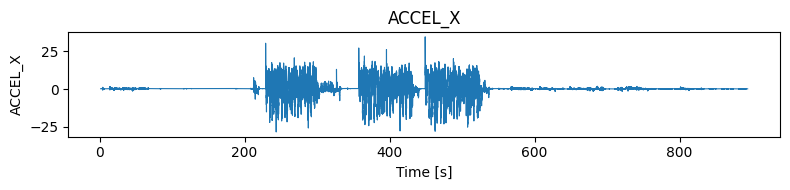

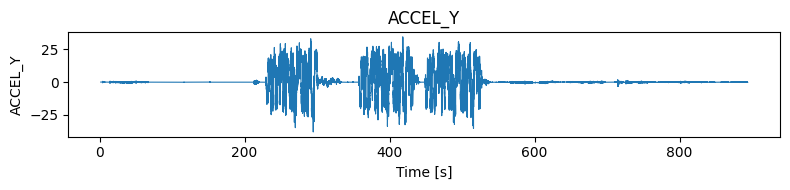

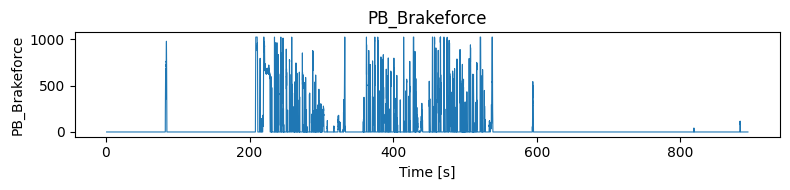

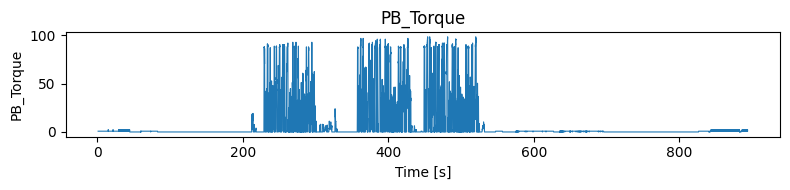

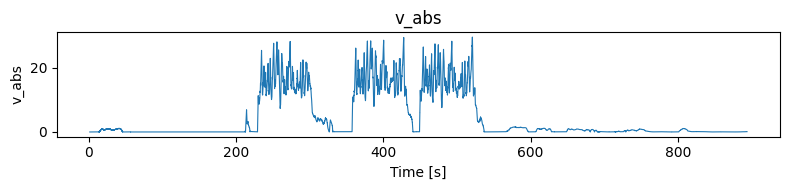

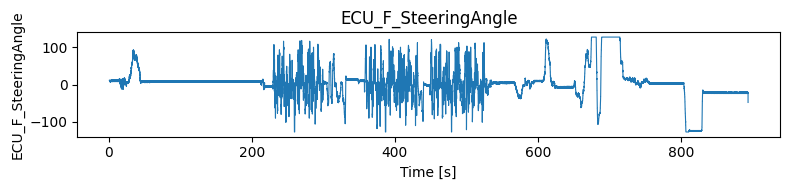

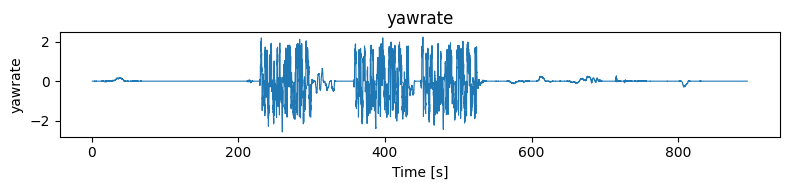

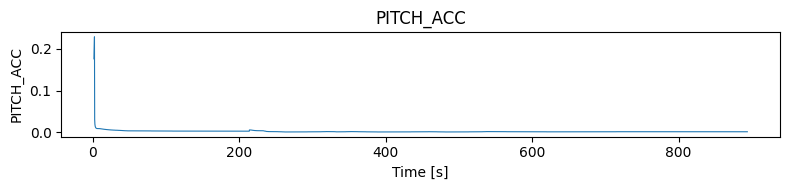

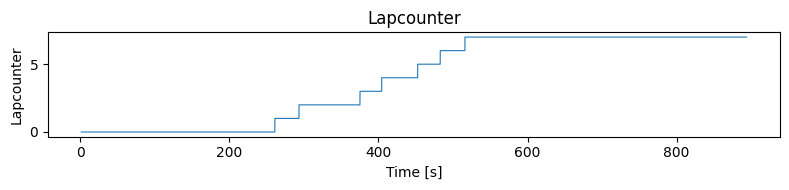

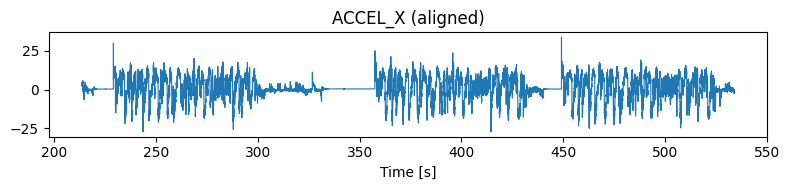

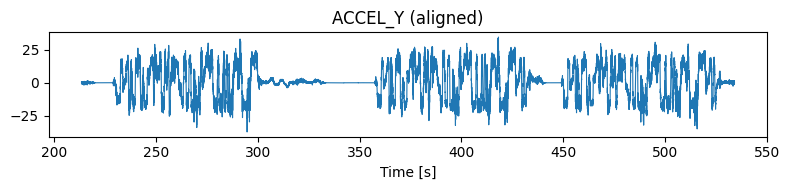

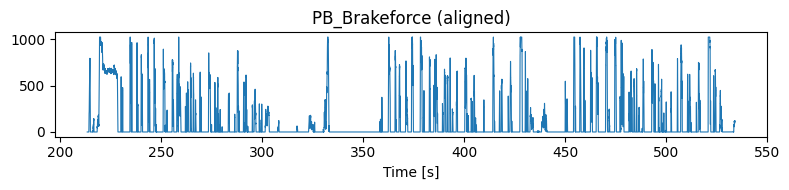

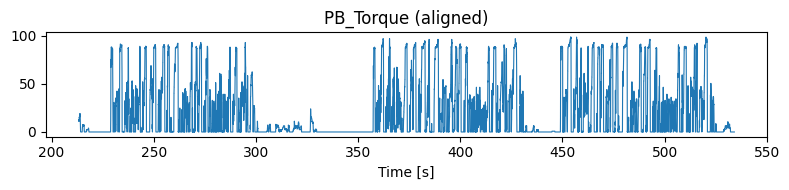

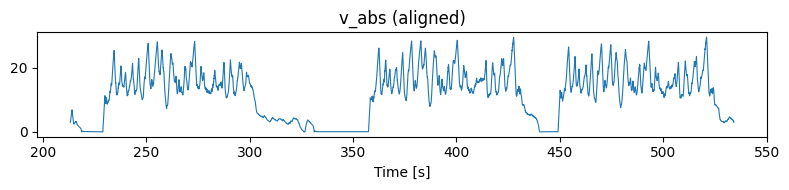

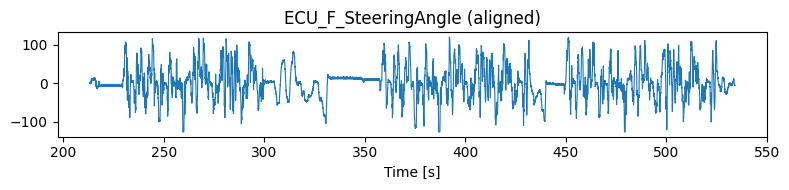

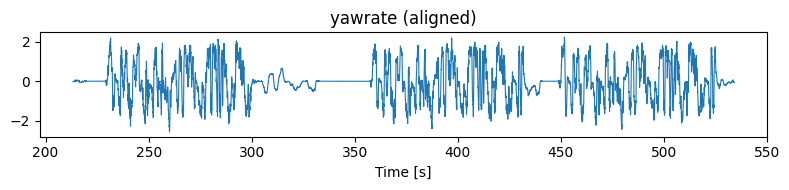

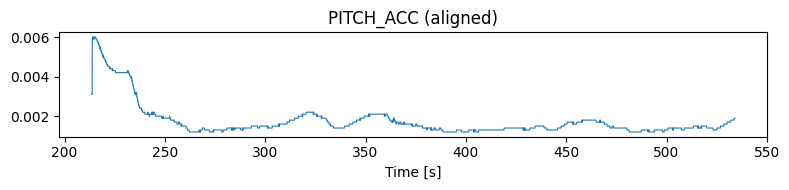

In [4]:
# Batch plots — self-contained (survives kernel restarts)

# Use inline backend for batch plotting (keeps widget cells separate)
try:
    get_ipython().run_line_magic('matplotlib', 'inline')
except Exception:
    pass

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

plt.close('all')
plt.ioff()  # non-interactive for loops

# Define 'pull' if it's not yet defined (after restart)
if 'pull' not in globals():
    def pull(mdf, ch):
        s = mdf.get(ch)
        return pd.DataFrame({"time_s": s.timestamps, "value": s.samples})

def _plot_series(ax, x, y, title, ylab=None):
    y = pd.to_numeric(pd.Series(y), errors='coerce').to_numpy()
    x = np.asarray(x)
    m = np.isfinite(x) & np.isfinite(y)
    if m.any():
        ax.plot(x[m], y[m], linewidth=0.8)
    else:
        ax.text(0.5, 0.5, "No finite data", ha="center", va="center", transform=ax.transAxes)
    ax.set_title(title)
    ax.set_xlabel("Time [s]")
    if ylab is not None:
        ax.set_ylabel(ylab)

# --- Raw channels (direct from MDF) ---
if 'mdf' in globals() and 'CH' in globals():
    for key, ch in CH.items():
        sig = pull(mdf, ch)
        fig, ax = plt.subplots(figsize=(8, 2))
        _plot_series(ax, sig["time_s"], sig["value"], f"{ch}", ylab=ch)
        fig.tight_layout(); fig.canvas.draw(); display(fig); plt.close(fig)
else:
    print("mdf/CH not defined. Rerun your loading cell.")

# --- Aligned and trimmed channels ---
if 'aligned' in globals():
    for col in aligned.columns:
        if col == "time_s":
            continue
        fig, ax = plt.subplots(figsize=(8, 2))
        _plot_series(ax, aligned["time_s"], aligned[col], f"{col} (aligned)")
        fig.tight_layout(); fig.canvas.draw(); display(fig); plt.close(fig)
else:
    print("aligned not defined. Rerun your preprocessing cell to create it.")

plt.ion()  # re-enable interactive mode for later cells


Smoothing and feature Engineering

In [5]:
from scipy.signal import savgol_filter
import numpy as np
import pandas as pd

# Light smoothing to reduce sensor noise while preserving shape
def smooth(x, window=11, poly=2):
    w = int(window) if int(window)%2==1 else int(window)+1
    w = max(5, w)
    return savgol_filter(x, w, poly) if len(x) > w else x

df = aligned.copy()

# Smoothed base signals
df["Speed"]     = smooth(df["v_abs"])              # forward velocity
df["LongAcc"]   = smooth(df["ACCEL_X"])            # longitudinal acceleration (IMU)
df["LatAcc"]    = smooth(df["ACCEL_Y"])            # lateral acceleration (IMU)
df["Brake"]     = smooth(df["PB_Brakeforce"])      # driver braking input
df["Torque"]    = smooth(df["PB_Torque"])          # driver torque/throttle proxy
df["Steer"]     = smooth(df["ECU_F_SteeringAngle"])
df["YawRate"]   = smooth(df["yawrate"])
df["PitchAcc"]  = smooth(df["PITCH_ACC"])

# Derived features (rates of change and magnitudes)
dt = np.gradient(df["time_s"].values)
df["dSpeed_dt"] = np.gradient(df["Speed"].values) / np.where(dt==0, np.nan, dt)    # speed rate
df["dSteer_dt"] = np.gradient(df["Steer"].values) / np.where(dt==0, np.nan, dt)    # steering rate
df["SteerAbs"]  = np.abs(df["Steer"].values)                                        # steering magnitude

# Cleanup invalid values
df = df.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)

# Compact feature matrix for ML
feature_cols = [
    "Speed",      # overall vehicle state
    "LongAcc",    # braking/accel via IMU
    "LatAcc",     # cornering load
    "Brake",      # braking input
    "Torque",     # drive input
    "SteerAbs",   # cornering intensity
    "dSpeed_dt",  # transitions in longitudinal state
    "dSteer_dt",  # transitions in steering
    "YawRate",    # rotational velocity
]
df_features = df[["time_s"] + feature_cols].copy()


Feature Scaling

In [6]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

scaler = StandardScaler()

# Build scaled feature matrix (time excluded)
X = df_features.drop(columns=["time_s"]).values
X_scaled = scaler.fit_transform(X)

# Store scaled features
df_scaled = df_features.copy()
df_scaled[df_features.columns[1:]] = X_scaled


Lap segmentation (not yet used)

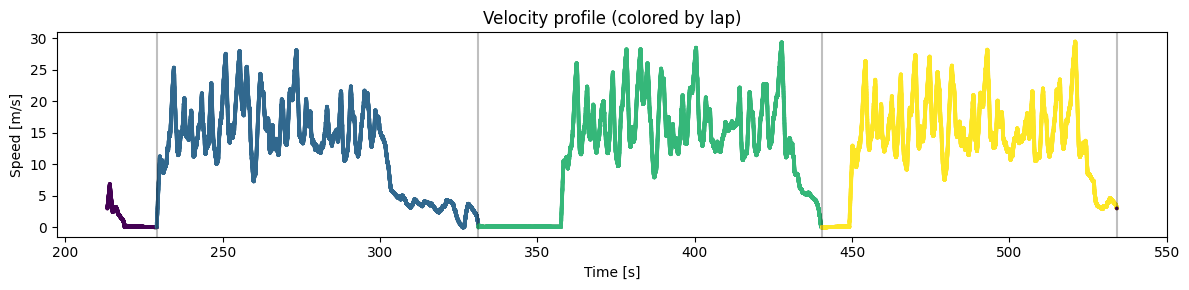

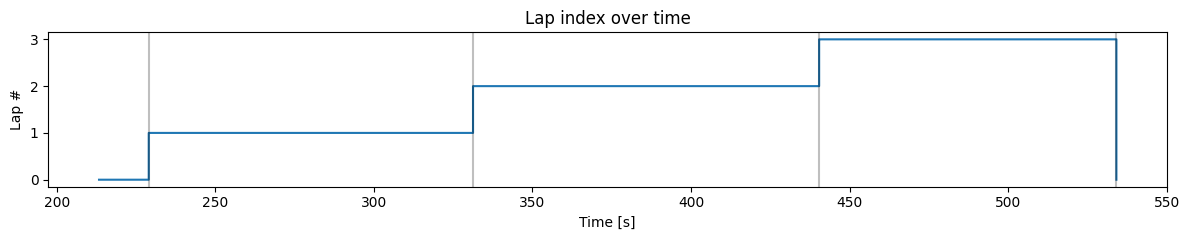

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Switch between LapCounter channel and heuristic
USELAPCOUNTER = 0
LAPTIME = 55  # expected lap time in seconds (for heuristic spacing)

t = aligned["time_s"].to_numpy()
speed = aligned["v_abs"].to_numpy()

if USELAPCOUNTER and "LapCounter" in aligned.columns:
    lap = aligned["LapCounter"].astype(int).to_numpy()
else:
    minima, _ = find_peaks(
        -speed,
        distance=int(LAPTIME / np.median(np.diff(t))),
        prominence=np.std(speed) * 0.3
    )
    bounds = np.r_[0, minima, len(speed) - 1]
    lap = np.zeros(len(speed), dtype=int)
    for i in range(len(bounds) - 1):
        lap[bounds[i]:bounds[i + 1]] = i

# Boundaries for visualization
bounds = np.where(np.diff(lap) != 0)[0] + 1

# Plot: speed colored by lap
plt.figure(figsize=(12,3))
plt.scatter(t, speed, c=lap, s=3)
for b in bounds:
    plt.axvline(t[b], color="k", alpha=0.25)
plt.xlabel("Time [s]")
plt.ylabel("Speed [m/s]")
plt.title("Velocity profile (colored by lap)")
plt.tight_layout()
plt.show()

# Plot: lap index over time
plt.figure(figsize=(12,2.5))
plt.step(t, lap, where="post", color="tab:blue")
for b in bounds:
    plt.axvline(t[b], color="k", alpha=0.25)
plt.xlabel("Time [s]")
plt.ylabel("Lap #")
plt.title("Lap index over time")
plt.tight_layout()
plt.show()


K Means Clustering and Visualization

In [8]:
# Setup: interactive matplotlib + basics
%pip install -q ipympl
%matplotlib widget

# If you don't already have this list in your notebook, define it here:
feature_cols = [
    "Speed","LongAcc","LatAcc","Brake","Torque",
    "SteerAbs","dSpeed_dt","dSteer_dt","YawRate"
]

# Quick sanity checks (will raise if something crucial is missing)
assert "time_s" in df_features, "df_features must contain 'time_s'"
missing = set(feature_cols) - set(df_scaled.columns)
assert not missing, f"df_scaled is missing {missing}"


Note: you may need to restart the kernel to use updated packages.


K-Means fit + attach labels

In [9]:
from sklearn.cluster import KMeans
import numpy as np

K = 5
X = df_scaled[feature_cols].values

km = KMeans(n_clusters=K, random_state=0, n_init="auto")
labels_km = km.fit_predict(X)

# attach to df_features for downstream plots
df_features = df_features.copy()
df_features["label_km"] = labels_km


Interactive time plot (slider + zoom/pan)

In [19]:
# Step 7a – Interactive time plot (ipympl)
import matplotlib.pyplot as plt
from ipywidgets import FloatRangeSlider, VBox
from IPython.display import display
import numpy as np

t = df_features["time_s"].to_numpy()
v = df_features["Speed"].to_numpy()
c = df_features["label_km"].to_numpy()

tmin, tmax = float(np.nanmin(t)), float(np.nanmax(t))
slider = FloatRangeSlider(
    value=[tmin, min(tmin + 20.0, tmax)],
    min=tmin, max=tmax, step=0.05,
    description="Time [s]", continuous_update=True, readout_format=".2f",
    layout={"width": "98%"}
)

fig, ax = plt.subplots(figsize=(12, 4))

def _update(*_):
    lo, hi = slider.value
    m = (t >= lo) & (t <= hi)
    ax.clear()
    for k in np.unique(c):
        mk = m & (c == k)
        if np.any(mk):
            ax.scatter(t[mk], v[mk], s=6, c=[plt.cm.tab10(k)], label=f"C{k}")
    ax.set_xlim(lo, hi)
    ax.set_xlabel("Time [s]"); ax.set_ylabel("Speed [m/s]")
    ax.set_title("K-Means clusters over time (interactive)")
    ax.legend(loc="upper right")
    fig.canvas.draw_idle()

slider.observe(_update, names="value")
_update()
display(VBox([slider, fig.canvas]))


Interactive feature-space explorer (choose any X/Y)

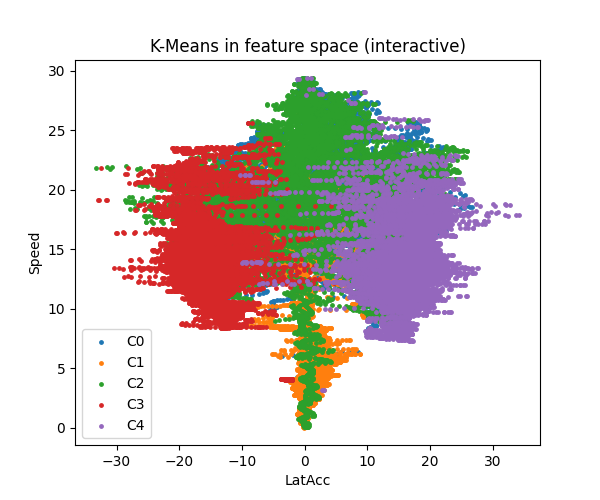

In [11]:
# Step 7b – Interactive feature-space explorer
import matplotlib.pyplot as plt
from ipywidgets import Dropdown, HBox, VBox
from IPython.display import display
import numpy as np

x_dd = Dropdown(options=feature_cols, value="LatAcc", description="X:")
y_dd = Dropdown(options=feature_cols, value="Speed",  description="Y:")

fig_fs, ax_fs = plt.subplots(figsize=(6, 5))
labels = df_features["label_km"].to_numpy()

def _draw_fs(*_):
    ax_fs.clear()
    x = df_features[x_dd.value].to_numpy()
    y = df_features[y_dd.value].to_numpy()
    for k in np.unique(labels):
        mk = (labels == k)
        if np.any(mk):
            ax_fs.scatter(x[mk], y[mk], s=6, c=[plt.cm.tab10(k)], label=f"C{k}")
    ax_fs.set_xlabel(x_dd.value); ax_fs.set_ylabel(y_dd.value)
    ax_fs.set_title("K-Means in feature space (interactive)")
    ax_fs.legend(loc="best")
    fig_fs.canvas.draw_idle()

x_dd.observe(_draw_fs, names="value")
y_dd.observe(_draw_fs, names="value")
_draw_fs()
display(VBox([HBox([x_dd, y_dd]), fig_fs.canvas]))


Interactive PCA view (zoom/pan)

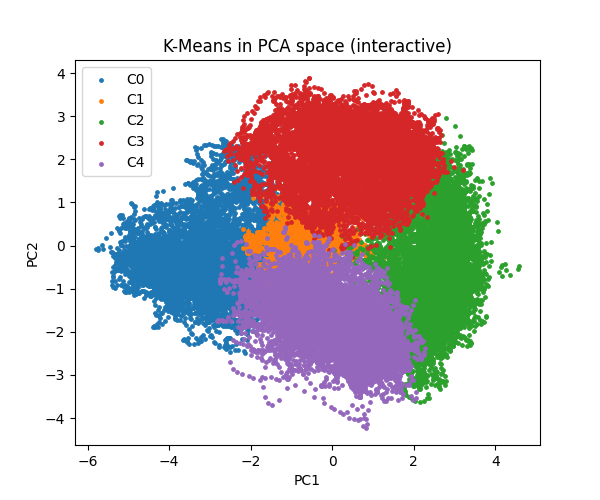

In [12]:
# Step 7c – Interactive PCA view
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

X = df_scaled[feature_cols].values
labels = df_features["label_km"].to_numpy()

pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(X)

fig_pca, ax_pca = plt.subplots(figsize=(6, 5))
for k in np.unique(labels):
    mk = (labels == k)
    ax_pca.scatter(Z[mk, 0], Z[mk, 1], s=6, c=[plt.cm.tab10(k)], label=f"C{k}")
ax_pca.set_xlabel("PC1"); ax_pca.set_ylabel("PC2")
ax_pca.set_title("K-Means in PCA space (interactive)")
ax_pca.legend(loc="best")
plt.show()


TODO:
1. Interpretieren, K CLustering verstehen
2. PLots über Strecke/Koordinaten?
3. GMM Clustering
4. Vergleich einzelner Fahrer/Rundencharacteristik



In [13]:
# === Step 8: Gaussian Mixture Model (GMM) clustering and visualization ===
# Assumptions:
# - `df_features` holds the engineered (UNSCALED) features + a column `time_s` (float seconds) and possibly `Lap`
# - `df_scaled` holds the SCALED versions of the same features, aligned 1:1 with df_features (same index)
# - Canonical feature list is defined as in prior steps:
#   feature_cols = ["Speed","LongAcc","LatAcc","Brake","Torque","SteerAbs","dSpeed_dt","dSteer_dt","YawRate"]

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.mixture import GaussianMixture

# 1) Prepare feature matrix (scaled) and time axis
X = df_scaled[feature_cols].values
t = df_features["time_s"].values  # x-axis for time plots

# 2) Fit GMM (same #components as KMeans for comparability)
n_components = 5
gmm = GaussianMixture(
    n_components=n_components,
    covariance_type="full",
    reg_covar=1e-6,
    random_state=42,
    max_iter=500,
    n_init=5,
)
gmm.fit(X)

# 3) Soft & hard assignments (index consistent with df_features/df_scaled)
labels_gmm = pd.Series(gmm.predict(X), index=df_scaled.index, name="label_gmm")
proba_gmm = pd.DataFrame(
    gmm.predict_proba(X),
    index=df_scaled.index,
    columns=[f"p_gmm_{k}" for k in range(n_components)],
)

# Attach to df_features (primary working frame)
df_features = df_features.copy()
df_features["label_gmm"] = labels_gmm.values
for col in proba_gmm.columns:
    df_features[col] = proba_gmm[col].astype(float)

# (Optional) If you also want labels/probas in `aligned`, merge via time_s
# aligned = aligned.merge(df_features[["time_s","label_gmm"] + list(proba_gmm.columns)], on="time_s", how="left")

# 4) Cluster-level statistics in ORIGINAL feature space (not scaled)
cluster_stats = (
    df_features[feature_cols + ["label_gmm"]]
    .groupby("label_gmm")
    .mean()
)

# 5) Score clusters to phases (ENTRY/MID/EXIT/STRAIGHT/COAST)
#    Normalize each feature across cluster means to [0,1] for robust scoring
eps = 1e-9
norm = (cluster_stats - cluster_stats.min()) / (cluster_stats.max() - cluster_stats.min() + eps)

# Helper: safe accessor returning 0 if a feature were missing (defensive)
def nz(col):
    return norm[col] if col in norm.columns else 0.0

phase_names = ["ENTRY", "MID", "EXIT", "STRAIGHT", "COAST"]
scores = pd.DataFrame(index=cluster_stats.index, columns=phase_names, dtype=float)

# Rationale:
# ENTRY: braking + steering build-up + deceleration
scores["ENTRY"] = (
    0.45 * nz("Brake")
    + 0.25 * nz("SteerAbs")
    + 0.15 * np.clip(-nz("dSpeed_dt"), 0, 1)  # negative dSpeed_dt => decel
    + 0.15 * np.clip(nz("YawRate"), 0, 1)
)

# MID: peak lateral + high steering + lower speed
scores["MID"] = (
    0.50 * np.abs(nz("LatAcc"))
    + 0.30 * nz("SteerAbs")
    + 0.20 * (1 - nz("Speed"))
)

# EXIT: torque + long accel + steering unwinds
scores["EXIT"] = (
    0.45 * nz("Torque")
    + 0.35 * np.clip(nz("LongAcc"), 0, 1)
    + 0.20 * (1 - nz("SteerAbs"))
)

# STRAIGHT: high speed, low lateral/steering, low brake
scores["STRAIGHT"] = (
    0.55 * nz("Speed")
    + 0.20 * (1 - np.abs(nz("LatAcc")))
    + 0.15 * (1 - nz("SteerAbs"))
    + 0.10 * (1 - nz("Brake"))
)

# COAST: medium speed, low brake/torque, low rates
scores["COAST"] = (
    0.35 * (1 - nz("Brake"))
    + 0.35 * (1 - nz("Torque"))
    + 0.15 * (1 - np.abs(nz("dSpeed_dt")))
    + 0.15 * (1 - np.abs(nz("dSteer_dt")))
)

# Map component -> phase and attach per-sample phase
gmm_phase_map = scores.idxmax(axis=1).to_dict()
df_features["phase_gmm"] = df_features["label_gmm"].map(gmm_phase_map)


# Objects produced:
# - gmm, labels_gmm, proba_gmm
# - df_features["label_gmm"], df_features["phase_gmm"], df_features[p_gmm_*]
# - gmm_phase_map, phase_time_share, phase_time_share_by_lap
# - Figures saved to figures/: gmm_time_series_speed_vs_time.png, gmm_probabilities_over_time.png, gmm_feature_space_latacc_vs_speed.png


In [20]:
# Step 8a – GMM: interactive Speed vs Time with slider (ipympl) — fixed
%matplotlib widget
import matplotlib.pyplot as plt
from ipywidgets import FloatRangeSlider, VBox
from IPython.display import display
import numpy as np

# optional: clear old figures when re-running
plt.close('all')

# data
phase_order = ["ENTRY","MID","EXIT","STRAIGHT","COAST"]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
phase_color = {p: colors[i % len(colors)] for i, p in enumerate(phase_order)}

t  = df_features["time_s"].to_numpy()
v  = df_features["Speed"].to_numpy()
ph = df_features["phase_gmm"].to_numpy()

tmin, tmax = float(np.nanmin(t)), float(np.nanmax(t))
slider = FloatRangeSlider(
    value=[tmin, min(tmin + 20.0, tmax)],
    min=tmin, max=tmax, step=0.05,
    description="Time [s]", continuous_update=True, readout_format=".2f",
    layout={"width": "98%"}
)

fig, ax = plt.subplots(figsize=(12, 4))

def _update(*_):
    lo, hi = slider.value
    m = (t >= lo) & (t <= hi)
    ax.clear()
    for p in phase_order:
        mk = m & (ph == p)
        if np.any(mk):
            ax.scatter(t[mk], v[mk], s=6, c=phase_color[p], label=p)
    ax.set_xlim(lo, hi)
    ax.set_xlabel("Time [s]"); ax.set_ylabel("Speed [m/s]")
    ax.set_title("GMM phases over time (interactive)")
    ax.legend(loc="upper right")
    fig.canvas.draw_idle()

slider.observe(_update, names="value")
_update()

display(VBox([slider, fig.canvas]))  # ← no plt.close(fig)


In [15]:
# Step 8b – GMM: interactive stacked probabilities over time (ipympl) — fixed
%matplotlib widget
import matplotlib.pyplot as plt
from ipywidgets import FloatRangeSlider, VBox
from IPython.display import display
import numpy as np

# avoid duplicate old figures when re-running
plt.close('all')

# --- pre-flight ---
p_cols = [c for c in df_features.columns if c.startswith("p_gmm_")]
n_components = len(p_cols)
assert n_components > 0, "GMM probabilities (p_gmm_*) not found. Run Step 8 first."
assert "time_s" in df_features and "phase_gmm" in df_features

# component -> phase mapping (use existing map or infer)
try:
    gmm_phase_map  # noqa: F821
except NameError:
    gmm_phase_map = {}
    probs = df_features[p_cols].to_numpy()
    winners = probs.argmax(axis=1)
    for k in range(n_components):
        mk = (winners == k)
        if mk.any():
            gmm_phase_map[k] = df_features.loc[mk, "phase_gmm"].mode().iat[0]
        else:
            gmm_phase_map[k] = "COAST"

phase_order = ["ENTRY","MID","EXIT","STRAIGHT","COAST"]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
phase_color = {p: colors[i % len(colors)] for i, p in enumerate(phase_order)}

# data
t = df_features["time_s"].to_numpy()
P = np.column_stack([df_features[f"p_gmm_{k}"].to_numpy() for k in range(n_components)])
comp_labels = [f"C{k} ({gmm_phase_map.get(k,'?')})" for k in range(n_components)]
comp_colors = [phase_color.get(gmm_phase_map.get(k, "COAST")) for k in range(n_components)]

# slider
tmin, tmax = float(np.nanmin(t)), float(np.nanmax(t))
slider_pb = FloatRangeSlider(
    value=[tmin, min(tmin + 20.0, tmax)],
    min=tmin, max=tmax, step=0.05,
    description="Time [s]", continuous_update=True, readout_format=".2f",
    layout={"width": "98%"}
)

# figure
fig_pb, ax_pb = plt.subplots(figsize=(12, 4))

def _update_pb(*_):
    lo, hi = slider_pb.value
    m = (t >= lo) & (t <= hi)
    x = t[m]
    Y = [P[m, k] for k in range(n_components)]
    ax_pb.clear()
    ax_pb.stackplot(x, Y, colors=comp_colors, labels=comp_labels)
    ax_pb.set_xlim(lo, hi)
    ax_pb.set_ylim(0, 1)
    ax_pb.set_xlabel("Time [s]"); ax_pb.set_ylabel("Probability")
    ax_pb.set_title("GMM component probabilities (stacked, interactive)")
    ax_pb.legend(loc="upper right", ncols=min(n_components, 5))
    fig_pb.canvas.draw_idle()

slider_pb.observe(_update_pb, names="value")
_update_pb()

display(VBox([slider_pb, fig_pb.canvas]))  # no plt.close(fig_pb)


In [21]:
# Step 8c – GMM: interactive feature-space explorer (ipympl), colored by phase — fixed
%matplotlib widget
import matplotlib.pyplot as plt
from ipywidgets import Dropdown, HBox, VBox
from IPython.display import display
import numpy as np

# avoid duplicate old figures when re-running
plt.close('all')

# available features (use only those present)
feature_cols_all = [
    "Speed","LongAcc","LatAcc","Brake","Torque",
    "SteerAbs","dSpeed_dt","dSteer_dt","YawRate"
]
feature_cols_avail = [c for c in feature_cols_all if c in df_features.columns]
assert "phase_gmm" in df_features.columns, "Run Step 8 first to create 'phase_gmm'."

# phases & colors
phase_order = ["ENTRY","MID","EXIT","STRAIGHT","COAST"]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
phase_color = {p: colors[i % len(colors)] for i, p in enumerate(phase_order)}

# dropdowns
x_dd = Dropdown(options=feature_cols_avail, value=feature_cols_avail[2] if "LatAcc" in feature_cols_avail else feature_cols_avail[0], description="X:")
y_dd = Dropdown(options=feature_cols_avail, value=feature_cols_avail[0] if "Speed"  in feature_cols_avail else feature_cols_avail[1], description="Y:")

# figure
fig_fs, ax_fs = plt.subplots(figsize=(6, 5))

def _draw_fs(*_):
    ax_fs.clear()
    for p in phase_order:
        mk = (df_features["phase_gmm"] == p)
        if mk.any():
            ax_fs.scatter(df_features.loc[mk, x_dd.value],
                          df_features.loc[mk, y_dd.value],
                          s=6, c=phase_color[p], label=p)
    ax_fs.set_xlabel(x_dd.value); ax_fs.set_ylabel(y_dd.value)
    ax_fs.set_title("GMM phases in feature space (interactive)")
    ax_fs.legend(loc="best")
    fig_fs.canvas.draw_idle()

x_dd.observe(_draw_fs, names="value")
y_dd.observe(_draw_fs, names="value")
_draw_fs()

display(VBox([HBox([x_dd, y_dd]), fig_fs.canvas]))


In [ ]:
Status:
GMM komisch getuned, phasen falsch
Plots sind komisch: restart zerschießts ab 7a. Wenn mann dann Einzelne Zelle nochmal laufen lässt, klappt es
